##### Add parent folder path

In [1]:
import sys; sys.path.insert(0, '..')

##### Import modules

In [2]:
import json
import time
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam

from transformers import BertTokenizer, BertModel

from trainer.model.res_net import ResNetEmbedding
from trainer.model.image_encoder import ImageEncoder, EncoderLayer
from trainer.model.captions_decoder import CaptionsDecoder, DecoderLayer
from trainer.model.attention_layers import MultiHeadAttentionLayer
from trainer.model.position_wise_feed_forward import PositionwiseFeedforwardLayer
from trainer.model.images_to_captions import Images2Captions

from trainer.training.train import train, evaluate, epoch_time 

from trainer.preprocessing.preprocess import PreprocessData
from trainer.dataloader.dataset import RelativeCaptioningDataset, MyCollator
from trainer.vocabulary.vocab import Vocab
from trainer.embeddings.embed import PositionalEncoding, BERTEmbedding
from trainer.utils.helpers import is_any_img_blacknwhite, is_any_img_not_exist
from trainer.utils.helpers import get_params, set_seed, count_parameters, initialize_weights

##### Get params

In [3]:
params = get_params()

IMAGES_DIR = "/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/images/dresses"
TRAIN_CAPTION_META_PATH = "/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/images_metadata/cap_dress_train.json"
TRAIN_EXPLODED_SAVE_PATH = "/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/images_metadata/cap_dress_train_exploded.jsonl"
VAL_CAPTION_META_PATH = "/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/images_metadata/cap_dress_val.json"
VAL_EXPLODED_SAVE_PATH = "/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/images_metadata/cap_dress_val_exploded.jsonl"

RESNET_OUT_DIM = 1024
BERT_LAST_N_LAYERS = params['model']['bert_embedder']['last_n_layers']

ENCODER_LAYERS = params['model']['encoder']['layers']
ENCODER_HEADS = params['model']['encoder']['heads']
ENCODER_DROPOUT = params['model']['encoder']['dropout']
ENCODER_PF_DIM = params['model']['encoder']['position_ff_dim']

DECODER_LAYERS = params['model']['decoder']['layers']
DECODER_HEADS = params['model']['decoder']['heads']
DECODER_DROPOUT = params['model']['decoder']['dropout']
DECODER_PF_DIM = params['model']['decoder']['position_ff_dim']

LEARNING_RATE = params['training']['lr']
N_EPOCHS = params['training']['epochs']
CLIP = params['training']['clip']
SEED = params['global']['seed']
BATCH_SIZE = params['dataloader']['train']['batch_size']
SHUFFLE = params['dataloader']['train']['shuffle']
NUM_WORKERS = params['dataloader']['train']['num_workers']

set_seed(seed=SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# local setup
client=None

##### Set up Dataloader

In [55]:
FILTERS = [is_any_img_not_exist, is_any_img_blacknwhite]

# Preprocess data
print("======= Preprocessing train set =======")
train_filter_agent = PreprocessData(caption_meta_path=TRAIN_CAPTION_META_PATH,
                                    images_dir=IMAGES_DIR,
                                    save_path=TRAIN_EXPLODED_SAVE_PATH,
                                    filters=FILTERS,
                                    client=client)

print("======= Preprocessing val set =======")
val_filter_agent = PreprocessData(caption_meta_path=VAL_CAPTION_META_PATH,
                                  images_dir=IMAGES_DIR,
                                  save_path=VAL_EXPLODED_SAVE_PATH,
                                  filters=FILTERS,
                                  client=client)

# Get sample of train and val data in order to check training pipeline
filtered_cap_dress_train = train_filter_agent.get_filtered_data()
filtered_cap_dress_val_test = val_filter_agent.get_filtered_data()
filtered_cap_dress_val = filtered_cap_dress_val_test[:2000]
filtered_cap_dress_test = filtered_cap_dress_val_test[2000:]



# Initialize BERT tokenizer
print("======= Creatng vocabulary =======")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Initialize Vocab
vocab_train = Vocab(captions=filtered_cap_dress_train, tokenizer=tokenizer)
vocab_val = Vocab(captions=filtered_cap_dress_val, tokenizer=tokenizer)
vocab_test = Vocab(captions=filtered_cap_dress_test, tokenizer=tokenizer)
vocab = vocab_train + vocab_val + vocab_test

# Initialize Dataset
transforms_list = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

print("======= Creating train Dataset object =======")
train_rel_cap_dataset = RelativeCaptioningDataset(list_ids=filtered_cap_dress_train,
                                                  images_dir=IMAGES_DIR,
                                                  transform=transforms_list,
                                                  client=client)

print("======= Creating val Dataset object =======")
val_rel_cap_dataset = RelativeCaptioningDataset(list_ids=filtered_cap_dress_val,
                                                images_dir=IMAGES_DIR,
                                                transform=transforms_list,
                                                client=client)

print("======= Creating test Dataset object =======")
test_rel_cap_dataset = RelativeCaptioningDataset(list_ids=filtered_cap_dress_test,
                                                images_dir=IMAGES_DIR,
                                                transform=transforms_list,
                                                client=client)
# Initialize Dataloader
collate_fn = MyCollator(tokenizer=tokenizer)

print("======= Creating train Dataloader object =======")
train_generator_params = {'batch_size': BATCH_SIZE,
                          'shuffle': False,
                          'num_workers': NUM_WORKERS}
train_iterator = DataLoader(dataset=train_rel_cap_dataset, collate_fn=collate_fn, **train_generator_params)

print("======= Creating val Dataloader object =======")
val_generator_params = {'batch_size': BATCH_SIZE,
                        'shuffle': False,
                        'num_workers': NUM_WORKERS}
val_iterator = DataLoader(dataset=val_rel_cap_dataset, collate_fn=collate_fn, **val_generator_params)

print("======= Creating test Dataloader object =======")
test_generator_params = {'batch_size': BATCH_SIZE,
                        'shuffle': False,
                        'num_workers': NUM_WORKERS}
test_iterator = DataLoader(dataset=test_rel_cap_dataset, collate_fn=collate_fn, **test_generator_params)

======= Preprocessing train set =======
Captions already filtered
======= Preprocessing val set =======
Captions already filtered
======= Creatng vocabulary =======
======= Creating train Dataset object =======
0/11902 samples loaded
1000/11902 samples loaded
2000/11902 samples loaded
3000/11902 samples loaded
4000/11902 samples loaded
5000/11902 samples loaded
6000/11902 samples loaded
7000/11902 samples loaded
8000/11902 samples loaded
9000/11902 samples loaded
10000/11902 samples loaded
11000/11902 samples loaded
All samples loaded successfully
======= Creating val Dataset object =======
0/2000 samples loaded
1000/2000 samples loaded
All samples loaded successfully
======= Creating test Dataset object =======
0/2014 samples loaded
1000/2014 samples loaded
2000/2014 samples loaded
All samples loaded successfully
======= Creating train Dataloader object =======
======= Creating val Dataloader object =======
======= Creating test Dataloader object =======


##### Set up models

In [20]:
 # Get pre-trained BERT for captions embeddings
print("======= Creating BERT model =======")
pretrained_bert = BertModel.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
                                            output_hidden_states=True)
_ = pretrained_bert.eval()
bert_model = BERTEmbedding(bert_model=pretrained_bert, n_last_layers=BERT_LAST_N_LAYERS)
hid_dim = bert_model.final_dim

# Get pre-trained ResNet for images embeddings
print("======= Creating Image Model model =======")
resnet_model = models.resnet101(pretrained=True)
resnet_embedding = ResNetEmbedding(resnet=resnet_model,
                                   out_resnet=RESNET_OUT_DIM,
                                   hid_dim=hid_dim)

# Get Image Encoder model
print("======= Creating Image Encoder model =======")
encoder_model = ImageEncoder(embedding_net=resnet_embedding,
                             hid_dim=hid_dim,
                             n_layers=ENCODER_LAYERS,
                             n_heads=ENCODER_HEADS,
                             pf_dim=ENCODER_PF_DIM,
                             dropout=ENCODER_DROPOUT)

# Get Captions Decoder model
print("======= Creating Captions Decoder model =======")
#vocab_len = len(vocab)
# Because there were a change in voab size due to data cleaning process and hence the new vocab is larger, the original was 1680
vocab_len = 1680
decoder_model = CaptionsDecoder(embedding_net=bert_model,
                                hid_dim=hid_dim,
                                output_dim=vocab_len,
                                n_layers=ENCODER_LAYERS,
                                n_heads=ENCODER_HEADS,
                                pf_dim=ENCODER_PF_DIM,
                                dropout=ENCODER_DROPOUT,
                                max_length=26)

# Get Images 2 Captions model
print("======= Assembling TRIC model =======")
tric_model = Images2Captions(encoder=encoder_model,
                             decoder=decoder_model,
                             trg_pad_idx=vocab.ids_to_ids_adj[vocab.tokens_to_ids['[PAD]']])

# Initialzie weights
_ = tric_model.apply(initialize_weights)

# Print number of trainable parameters
print(f'The model has {count_parameters(tric_model):,} trainable parameters')

# Set up optimizer and loss function
#print("======= Setting up optimizer and loss function =======")
#optimizer = Adam(tric_model.parameters(),
#                 lr=LEARNING_RATE,
#                 betas=(0.9, 0.98))
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
#                                                       mode='min',
#                                                       factor=0.8,
#                                                       patience=20,
#                                                       verbose=True)
#trg_pad_idx = vocab.ids_to_ids_adj[vocab.tokens_to_ids['[PAD]']]
#criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

======= Creating BERT model =======
======= Creating Image Model model =======
======= Creating Image Encoder model =======
======= Creating Captions Decoder model =======
======= Assembling TRIC model =======
The model has 42,254,736 trainable parameters


In [12]:
42_322_408 - 42_254_736

67672

In [16]:
a = 1024
(67672 - a)/a

65.0859375

##### Set up training

In [ ]:
optimizer = torch.optim.Adam(tric_model.parameters(), lr = 0.0001)
TRG_PAD_IDX = vocab.ids_to_ids_adj[vocab.tokens_to_ids['[PAD]']]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
%%time
best_valid_loss = float('inf')

for epoch in range(80):
    
    start_time = time.time()
    
    train_loss = train(model=tric_model,
                       iterator=train_iterator,
                       optimizer=optimizer,
                       criterion=criterion,
                       vocab=vocab)
    
    valid_loss = evaluate(model=tric_model,
                          iterator=val_iterator,
                          criterion=criterion,
                          vocab=vocab)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(tric_model.state_dict(), 'data/models/model_poc_only256samples_static_embeds_v3.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    torch.save(tric_model.state_dict(), 'data/models/model_poc_last_train_v3.pt')

## Plot loss

### Training setup
"--batch-size=512" <br>
"--shuffle-train", <br>
"--num-workers=0", <br>
"--enc-layers=3", <br>
"--enc-heads=8", <br>
"--enc-pos-ff-dim=2048", <br>
"--enc-dropout=0.1", <br>
"--dec-layers=3", <br>
"--dec-heads=8", <br>
"--dec-pos-ff-dim=2048", <br>
"--dec-dropout=0.1", <br>
"--bert-last-n-layers=4", <br>
"--img-model-out-dim=1024", <br>
"--num-epochs=150", <br>
"--learning-rate=0.0003", <br>
"--clip=2"

### Machine used
Configure a master worker with 4 P100 GPU

In [56]:
LOSS_LOGS_PATH = "/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/logs/downloaded-logs-20210207-155720.json"

In [89]:
# Load logs
with open(LOSS_LOGS_PATH, mode="r") as file:
    logs = json.load(file)
    
# Filter those concerning TRAIN and EVAL loss values    
train_logs = []
eval_logs = []
for log in logs:
    if 'jsonPayload' in log.keys():
        if "[TRAIN]" in log['jsonPayload']['message']:
            train_logs.append(log['jsonPayload']['message'].replace("\n", ""))

        if "[EVAL]" in log['jsonPayload']['message']:
            eval_logs.append(log['jsonPayload']['message'].replace("\n", ""))
            
# Filter only loss values
train_loss = [float(log.split("loss: ")[-1]) for log in train_logs]
eval_loss = [float(log.split("loss: ")[-1]) for log in eval_logs]

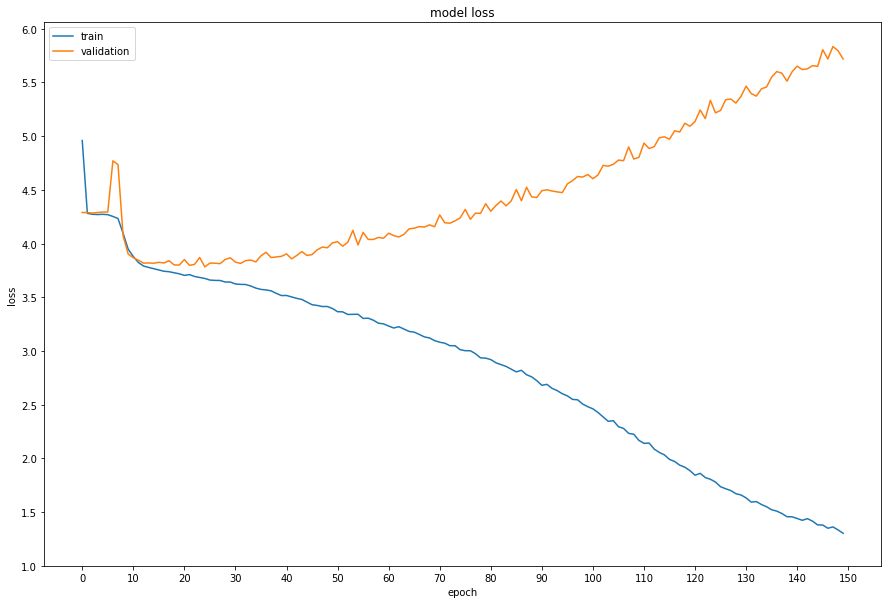

In [111]:
# Plot loss
plt.figure(figsize=(15, 10))
plt.plot(train_loss)
plt.plot(eval_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(list(range(0,151,10)))
plt.yticks(np.arange(1.0, 6.1, 0.5))
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig("/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/plots/loss_figure.jpg")
plt.show()

## Calculate BLEU

In [89]:
from tqdm import tqdm

In [21]:
MODEL_PATH = '/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/models/tric_pytorch_job_20210125_134451_models_model_20210125_155116_model.pth'


# original saved file with DataParallel
state_dict = torch.load(f=MODEL_PATH, map_location=torch.device('cpu'))
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
tric_model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [95]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(model, iterator, vocab, device, max_len):
    
    targets_list = []
    predictions_list = []
    
    for batch in iterator:
        # Get batch
        target_batch, cand_batch, captions_batch, segments_ids_batch, cap_lengths = batch
        
        # Produce predicted caption, reference caption pairs for single batch
        batch_true_list, batch_predicted_list = get_batch_pairs(target_batch, cand_batch, captions_batch, model, vocab, device, max_len)
        
        # Add batch pairs to all pairs
        targets_list += batch_true_list
        predictions_list += batch_predicted_list
        break
        
    return bleu_score(predictions_list, targets_list), targets_list, predictions_list
        
            
def get_batch_pairs(target_batch, cand_batch, captions_batch, model, vocab, device, max_len):
    batch_true = []
    batch_predicted = []
    for i in tqdm(range(target_batch.size()[0])):
        # Get target and candidate images
        trg_img = target_batch[i].unsqueeze(0).to(device)
        cand_img = cand_batch[i].unsqueeze(0).to(device)
        true_caption = captions_batch[i]
        
        cap_true, cap_predicted = get_single_pair(trg_img, cand_img, true_caption, model, vocab, device, max_len)
        
        batch_true.append([cap_true])
        batch_predicted.append(cap_predicted)
        
    return batch_true, batch_predicted
        
        
def get_single_pair(trg_img, cand_img, true_caption, model, vocab, device, max_len):
    special_tokens = ['[CLS]', '[SEP]', '[PAD]']
    model.eval()
    with torch.no_grad():
        encoded_images = model.encoder((trg_img, cand_img))

        caption_indexes = [vocab.tokens_to_ids['[CLS]']]

        for i in range(max_len):
            caption_tensor = torch.LongTensor(caption_indexes).unsqueeze(0).to(device)
            caption_mask = model.make_trg_mask(caption_tensor, device)
            caption_seg_ids = torch.ones_like(caption_tensor)

            with torch.no_grad():
                output, attention = model.decoder(caption_tensor, caption_seg_ids, caption_mask, encoded_images)

            pred_token = output.argmax(2)[:, -1].item()
            pred_token_idx = vocab.ids_adj_to_ids[pred_token]
            caption_indexes.append(pred_token_idx)

            if pred_token_idx == vocab.tokens_to_ids['[SEP]']:
                break
                
    caption_tokens = [vocab.ids_to_tokens[id_] for id_ in caption_indexes]
    caption_predicted = [tok for tok in caption_tokens if tok not in special_tokens]
    
    caption_true = [vocab.ids_to_tokens[id_.item()] for id_ in true_caption]
    caption_true = [tok for tok in caption_true if tok not in special_tokens]
    
    return caption_true, caption_predicted

In [96]:
train_bleu_score, trg_list, pred_list = calculate_bleu(model=tric_model, iterator=train_iterator, vocab=vocab, device=device, max_len=15)

100%|██████████| 512/512 [11:33<00:00,  1.35s/it]


In [97]:
train_bleu_score

0.2693479657173157

In [98]:
val_bleu_score, trg_list_val, pred_list_val = calculate_bleu(model=tric_model, iterator=val_iterator, vocab=vocab, device=device, max_len=15)

100%|██████████| 512/512 [09:58<00:00,  1.17s/it]


In [100]:
val_bleu_score

0.0

In [104]:
test_bleu_score, trg_list_test, pred_list_test = calculate_bleu(model=tric_model, iterator=test_iterator, vocab=vocab, device=device, max_len=15)

100%|██████████| 512/512 [11:47<00:00,  1.38s/it]


In [105]:
test_bleu_score

0.0

## Producing Captions

### TRAIN
good examples: 30, 33, 35, 48, 52, 66 <br>
examples when it is describing the candidate image: 60 <br>
examples when it is correct while the original caption was wrong: 62

### VAL
good meaning but close to 0 when BLEU score: 1, 45, 57, 117<br>
completely wrong: 3, 125, 130 (describing the candidate), 450 <br>
very good description of a candidate: 189, 216,

In [1927]:
batch = next(iter(val_iterator))
target_batch, cand_batch, captions_batch, segments_ids_batch, cap_lengths = batch

In [2118]:
MAX_LEN = 15 # put into config
IMAGE_PAIR_ID = 139
captions_list = []

tric_model.eval()
with torch.no_grad():
    target = target_batch[IMAGE_PAIR_ID].unsqueeze(0).to(device)
    cand = cand_batch[IMAGE_PAIR_ID].unsqueeze(0).to(device)
    encoded_images = tric_model.encoder((target, cand))

    caption_indexes = [vocab.tokens_to_ids['[CLS]']]

    for i in range(MAX_LEN):
        caption_tensor = torch.LongTensor(caption_indexes).unsqueeze(0).to(device)
        caption_mask = tric_model.make_trg_mask(caption_tensor, device)
        caption_seg_ids = torch.ones_like(caption_tensor)

        with torch.no_grad():
            output, attention = tric_model.decoder(caption_tensor, caption_seg_ids, caption_mask, encoded_images)

        pred_token = output.argmax(2)[:, -1].item()
        pred_token_idx = vocab.ids_adj_to_ids[pred_token]
        caption_indexes.append(pred_token_idx)

        if pred_token_idx == vocab.tokens_to_ids['[SEP]']:
            break

caption_tokens = [vocab.ids_to_tokens[id_] for id_ in caption_indexes]

In [2119]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2120]:
caption_tokens

['[CLS]', 'is', 'longer', 'and', 'has', 'longer', 'sleeves', '[SEP]']

In [2121]:
real_caption = [vocab.ids_to_tokens[id_.item()] for id_ in captions_batch[IMAGE_PAIR_ID]]
real_caption

['[CLS]',
 'is',
 'black',
 'and',
 'less',
 'revealing',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [2101]:
target_org_path = IMAGES_DIR + "/" + filtered_cap_dress_val[IMAGE_PAIR_ID]['target'] + ".jpg"
candidate_org_path = IMAGES_DIR + "/" + filtered_cap_dress_val[IMAGE_PAIR_ID]['candidate'] + ".jpg"

In [2071]:
target_org_path

'/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/images/dresses/B007ORZ1PG.jpg'

In [2072]:
candidate_org_path

'/Users/wojtekpyrak/Paluch/GIT/USER_SIMULATOR/transformer-based-user-modeling/data/images/dresses/B0092QK9AY.jpg'

In [2073]:
filtered_cap_dress_val[IMAGE_PAIR_ID]

{'target': 'B007ORZ1PG',
 'candidate': 'B0092QK9AY',
 'caption': 'is solid nude color'}

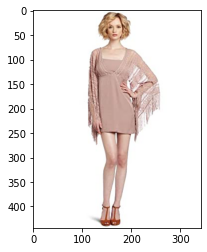

In [2074]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(target_org_path)
imgplot = plt.imshow(img)
plt.show()

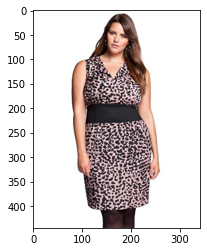

In [2075]:
img = mpimg.imread(candidate_org_path)
imgplot = plt.imshow(img)
plt.show()

In [2076]:
img_target = target.squeeze(0)
img_candidate = cand.squeeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


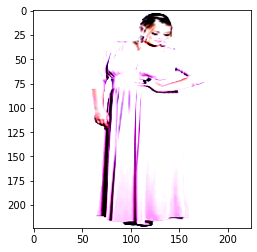

In [1994]:
show(img_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


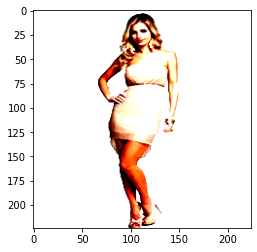

In [1940]:
show(img_candidate)

2val
original: is longer and more colorful
generated: is white and has stripes with no sleeves

3val
original: has a multi-colored pattern
generated: is white and longer and more more

1train
original: blue with wider skirt
generated: has a black and is is redder belt